In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Google Colab GPU Details




In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 26.4 GB  | Proc size: 112.4 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


# Import the Relvant Libraries

In [3]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    # Load the TensorBoard notebook extension
    %load_ext tensorboard   
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp

In [4]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import imgaug as aug
import pandas as pd
import numpy as np
import datetime
import h5py
import cv2
import os

In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [6]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/

#Check the present working directory using pwd command
!pwd

/content/gdrive/My Drive/Kaggle
/content/gdrive/My Drive/Kaggle


In [7]:
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.5MB/s 
     |████████████████████████████████| 5.3MB 7.1MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 133kB 36.6MB/s 
     |████████████████████████████████| 112kB 44.0MB/s 


In [8]:
!kaggle datasets download -d harshu1992/covid19detection

 99% 858M/863M [00:07<00:00, 155MB/s]
100% 863M/863M [00:07<00:00, 115MB/s]


In [9]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  covid19detection.zip
  inflating: DATASET/0-NORMAL/00000080_005.png  
  inflating: DATASET/0-NORMAL/00000083_000.png  
  inflating: DATASET/0-NORMAL/00000165_008.png  
  inflating: DATASET/0-NORMAL/00000188_001.png  
  inflating: DATASET/0-NORMAL/00000194_004.png  
  inflating: DATASET/0-NORMAL/00000206_000.png  
  inflating: DATASET/0-NORMAL/00000231_005.png  
  inflating: DATASET/0-NORMAL/00000239_003.png  
  inflating: DATASET/0-NORMAL/00000246_018.png  
  inflating: DATASET/0-NORMAL/00000265_004.png  
  inflating: DATASET/0-NORMAL/00000269_001.png  
  inflating: DATASET/0-NORMAL/00000272_003.png  
  inflating: DATASET/0-NORMAL/00000276_000.png  
  inflating: DATASET/0-NORMAL/00000277_002.png  
  inflating: DATASET/0-NORMAL/00000278_000.png  
  inflating: DATASET/0-NORMAL/00000289_001.png  
  inflating: DATASET/0-NORMAL/00000318_004.png  
  inflating: DATASET/0-NORMAL/00000334_005.png  
  inflating: DATASET/0-NORMAL/00000359_006.png  
  inflating: DATASET/0-NORMAL/00000362

In [10]:
dataset_path = '/content/gdrive/MyDrive/Kaggle/DATASET'
# Read all files from path
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []

[INFO] loading images...


# Display Images

In [11]:
def show_image(img):
    if type(img) == 'str':
        img = plt.imread(img)
    plt.imshow(img, cmap = 'gray')
    plt.title('Example X-Ray scan')
    plt.grid(False)
    plt.axis('off')
    plt.show()

# Select Random 364 Images 

In [12]:
# select number of classes to be loaded for Normal, Bacterial Pneumonia and Viral Pneumonia patients 
num_normal = 364

n = 0 #initialize all 3 counters to limit the number of images loaded 
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    if label == '0-NORMAL' and n < num_normal:
      data.append((imagePath,label))
      n += 1

    elif label == '1-COVID':
      data.append((imagePath,label))


# Create DataFrame 

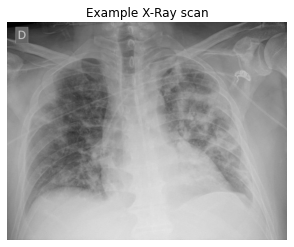

In [13]:
# Get a pandas dataframe from the data we have in our list 
data = pd.DataFrame(data, columns=['image', 'label'],index=None)

# Shuffle the data 
data = data.sample(frac=1.).reset_index(drop=True)
tmp_img = plt.imread(data["image"][0])
show_image(tmp_img)
del tmp_img
data["label"] = LabelEncoder().fit_transform(data["label"])


In [14]:
data

,image,label
0,/content/gdrive/MyDrive/Kaggle/DATASET/1-COVID...,1
1,/content/gdrive/MyDrive/Kaggle/DATASET/0-NORMA...,0
2,/content/gdrive/MyDrive/Kaggle/DATASET/0-NORMA...,0
3,/content/gdrive/MyDrive/Kaggle/DATASET/0-NORMA...,0
4,/content/gdrive/MyDrive/Kaggle/DATASET/1-COVID...,1
...,...,...
540,/content/gdrive/MyDrive/Kaggle/DATASET/0-NORMA...,0
541,/content/gdrive/MyDrive/Kaggle/DATASET/0-NORMA...,0
542,/content/gdrive/MyDrive/Kaggle/DATASET/0-NORMA...,0
543,/content/gdrive/MyDrive/Kaggle/DATASET/0-NORMA...,0


# Visualization example X-ray scans


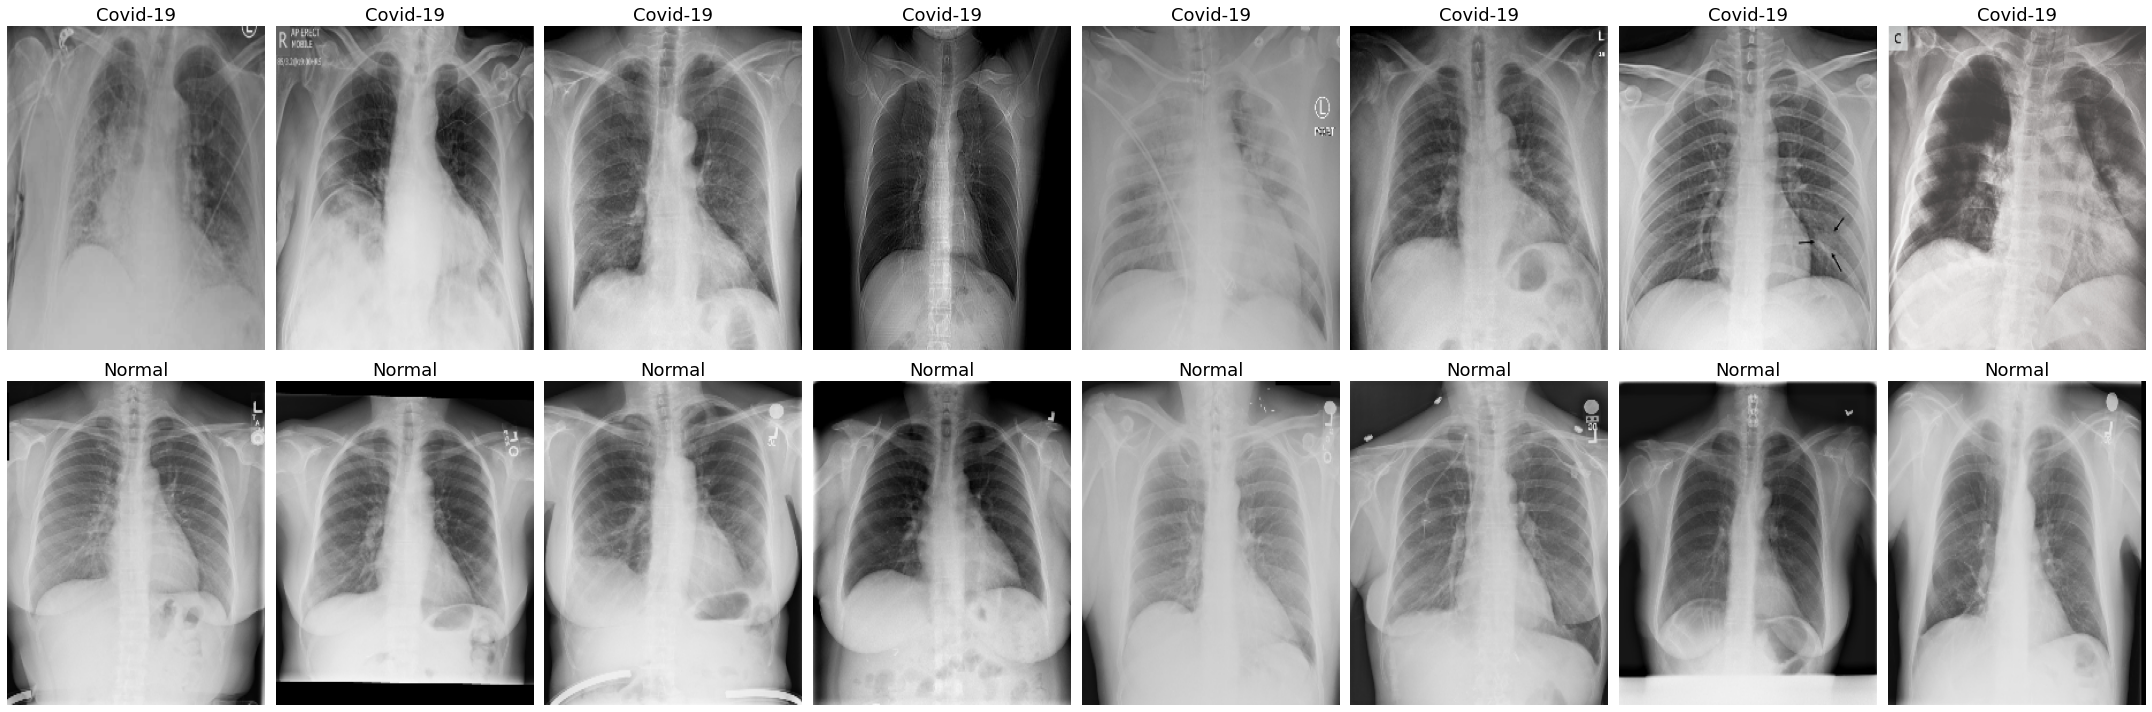

In [15]:
# select the number of sampels to be plotted for each class
sample_num = 8
normal_samples = (data[data['label']==0]['image'].iloc[30:30+sample_num]).tolist()
covid_samples = (data[data['label']==1]['image'].iloc[5:5+sample_num]).tolist()

samples = covid_samples + normal_samples
del covid_samples, normal_samples

color = 'black'

# Plot the data 
f, ax = plt.subplots(2,sample_num, figsize=(30,10))
for i in range(sample_num*2):
    img = cv2.imread(samples[i])
    img = cv2.resize(img, (224, 224))
    if i<sample_num:
        ax[0, i%sample_num].imshow(img, cmap='gray')
        ax[0, i%sample_num].set_title("Covid-19", fontsize=18, color = color)
    else:
        ax[1, i%sample_num].imshow(img, cmap='gray')
        ax[1, i%sample_num].set_title("Normal", fontsize=18, color = color)

    ax[i//sample_num, i%sample_num].axis('off')
    ax[i//sample_num, i%sample_num].set_aspect('auto')

plt.tight_layout()
plt.show()


Select training, validation and testing data split

In [16]:
train_data, test_data = train_test_split(data, test_size=0.20,shuffle=True,random_state=10)
train_data, valid_data = train_test_split(train_data, test_size=0.20, random_state=12)

print('\nNumber of training pairs: ', len(train_data))
print('Number of validation pairs: ', len(valid_data))
print('Number of testing pairs: ', len(test_data))


Number of training pairs:  348
Number of validation pairs:  88
Number of testing pairs:  109


In [17]:
data['label'].value_counts()

0    364
1    181
Name: label, dtype: int64

	----- Total Dataset ------
		 [364 181]

-- Train Set -- -- Validation Set -- -- Test Set --
   [229 119] 	      [62 26] 	         [73 36] 




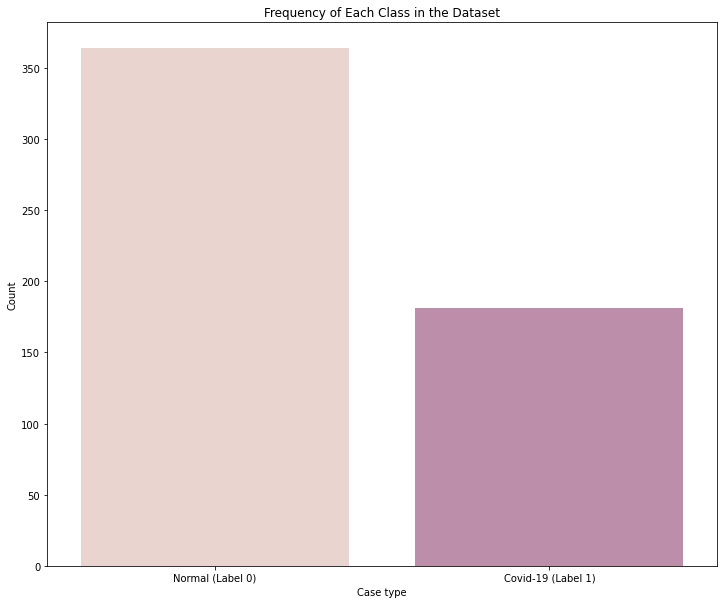

In [18]:
cases_count = data['label'].value_counts()
print('\t----- Total Dataset ------')
print('\t\t', cases_count.ravel())

cases_count_train = train_data['label'].value_counts()
cases_count_validation = valid_data['label'].value_counts()
cases_count_test = test_data['label'].value_counts()
print('\n-- Train Set -- -- Validation Set -- -- Test Set --')
print('  ', cases_count_train.ravel(),'\t     ',cases_count_validation.ravel(), '\t        ', cases_count_test.ravel(), '\n\n')

# Plot the results 
plt.figure(figsize=(12,10))
sns.barplot(x=cases_count.index, y= cases_count.values, palette=sns.cubehelix_palette(4, start=2.5, rot=0.6))
plt.title('Frequency of Each Class in the Dataset')
plt.xlabel('Case type')
plt.ylabel('Count')
plt.xticks(range(len(cases_count.index)), ['Normal (Label 0)', 'Covid-19 (Label 1)'])
plt.yticks()
plt.show()

# Converting DataFrame -> Array

In [19]:
def get_arrays(df):
    print('[INFO] retreiving images from path...')
    images, labels = [], []

    img_paths = df.iloc[:,0].values # extract image paths from DataFrame
    labels_ = df.iloc[:,1].values # extract labels from DataFrame

    for i,path in enumerate(img_paths):
        # load the image, swap color channels, and resize it to be a fixed 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(path)

        # check if it's grayscale
        if image.shape[2]==1:
            print(image.shape[2])
            image = np.dstack([image, image, image])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512))
        image = image / 255.0 
        encoded_label = tf.keras.utils.to_categorical(labels_[i], num_classes=2)
        images.append(image)
        labels.append(encoded_label)

    return np.array(images), np.array(labels)

In [20]:
trainX, trainY = get_arrays(train_data)
validX, validY = get_arrays(valid_data)
testX, testY = get_arrays(test_data)

[INFO] retreiving images from path...
[INFO] retreiving images from path...
[INFO] retreiving images from path...


In [21]:
trainX.shape

(348, 512, 512, 3)

In [22]:
# calculating class weights from trainset for class imabalance
print('[INFO] calculating class weights...')
print(cases_count_train)
covid_pneumonia_count = cases_count_train.ravel()[1]
normal_count = cases_count_train.ravel()[0]

class_weights = {0: 1.0, 1: normal_count/covid_pneumonia_count} 

print('\nclass weights: ', class_weights) 

[INFO] calculating class weights...
0    229
1    119
Name: label, dtype: int64

class weights:  {0: 1.0, 1: 1.9243697478991597}


Build our model on top of pre-trained VGG-19 model


In [23]:
def build_model(baseModel):

      # Make all pre-trained layers non-trainable 
      for layer in baseModel.layers[:-3]:
          layer.trainable = False

      # Add trainable fully-connected (FC) layers for predictions
      newModel = baseModel.output
      newModel = tf.keras.layers.AveragePooling2D(pool_size=(3, 3))(newModel)
      newModel = tf.keras.layers.Flatten(name="flatten")(newModel)
      newModel = tf.keras.layers.Dense(64, activation="relu")(newModel)
      newModel = tf.keras.layers.Dropout(0.4)(newModel)
      newModel = tf.keras.layers.Dense(2, activation="sigmoid")(newModel)

      # Stack the FC layers on top of VGG19 model
      model = tf.keras.models.Model(inputs=baseModel.input, outputs=newModel, name='Covid19_Detector')

      return model

baseModel = classifier = tf.keras.applications.VGG19(weights="imagenet", include_top=False,
            input_tensor = tf.keras.layers.Input(shape=(512,512,3)))
model = build_model(baseModel)

model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics=["accuracy"])

# initialize the training data augmentation object
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale= 1 / 255.0,
    rotation_range=15,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    fill_mode="nearest")

  
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()


early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy', 
verbose=1,
patience=10,
mode='max',
restore_best_weights=True
)

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=0, 
                                                                    mode='auto', min_delta=0.0002, cooldown=0, min_lr=0)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('VGG19_model_weights.h5', 
                                                      monitor='val_accuracy', verbose=0, save_best_only=True, 
                                                      save_weights_only=True, mode='max')


callbacks = [early_stopping, reduce_on_plateau, model_checkpoint]

batch_size = 15
epochs = 100
results = model.fit(
    train_datagen.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=valid_datagen.flow(validX, validY, batch_size=batch_size),
    validation_steps=len(validX) // batch_size,
    class_weight = class_weights,
    epochs=epochs,
    callbacks=callbacks
)

80142336/80134624 [==============================] - 4s 0us/step
Epoch 1/100
23/23 [==============================] - 19s 840ms/step - loss: 1.1006 - accuracy: 0.4474 - val_loss: 0.6903 - val_accuracy: 0.5467
Epoch 2/100
23/23 [==============================] - 19s 813ms/step - loss: 0.9055 - accuracy: 0.4114 - val_loss: 0.6005 - val_accuracy: 0.8400
Epoch 3/100
23/23 [==============================] - 18s 789ms/step - loss: 0.8651 - accuracy: 0.6937 - val_loss: 0.5863 - val_accuracy: 0.8000
Epoch 4/100
23/23 [==============================] - 18s 795ms/step - loss: 0.7447 - accuracy: 0.6006 - val_loss: 0.4255 - val_accuracy: 0.8400
Epoch 5/100
23/23 [==============================] - 19s 814ms/step - loss: 0.7710 - accuracy: 0.7447 - val_loss: 0.4780 - val_accuracy: 0.8933
Epoch 6/100
23/23 [==============================] - 19s 835ms/step - loss: 0.6633 - accuracy: 0.7688 - val_loss: 0.4126 - val_accuracy: 0.8533
Epoch 7/100
23/23 [==============================] - 19s 804ms/step - l

In [24]:
model.summary()

Model: "Covid19_Detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)

Analyse Results from the Test Set

In [25]:
# Make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=batch_size)
print('Number of test scans: ', len(testX))
print('Predicted class probabilities:')
print()

for n in range(len(predIdxs)):
    my_formatted_list = ['%.2f' % elem for elem in predIdxs[n]]
    print(f'{n}:  ', *my_formatted_list)

# Find the predicted labels 
predIdxs = np.argmax(predIdxs, axis=1)
print('\nPredicted outcome (Covid=1, Normal=0):')
print(predIdxs)
print('Ground-truth outcome:')
# print(testY)
trueIdxs = np.argmax(testY, axis=1)
print(trueIdxs)

[INFO] evaluating network...
Number of test scans:  109
Predicted class probabilities:

0:   0.50 0.50
1:   0.93 0.07
2:   0.99 0.00
3:   0.51 0.50
4:   0.72 0.25
5:   0.66 0.34
6:   1.00 0.00
7:   0.89 0.03
8:   0.99 0.00
9:   0.00 1.00
10:   0.95 0.04
11:   0.62 0.39
12:   0.50 0.50
13:   0.89 0.12
14:   0.94 0.05
15:   0.91 0.08
16:   0.72 0.25
17:   0.00 1.00
18:   0.57 0.41
19:   0.07 0.94
20:   0.75 0.24
21:   0.19 0.81
22:   0.27 0.75
23:   0.45 0.54
24:   0.97 0.02
25:   0.50 0.50
26:   0.50 0.50
27:   0.88 0.11
28:   0.50 0.50
29:   0.46 0.55
30:   0.72 0.26
31:   0.91 0.06
32:   0.99 0.00
33:   0.78 0.19
34:   0.99 0.00
35:   0.87 0.10
36:   0.00 1.00
37:   0.95 0.03
38:   0.97 0.02
39:   0.85 0.14
40:   0.41 0.59
41:   0.98 0.01
42:   0.93 0.06
43:   0.65 0.34
44:   0.99 0.00
45:   0.03 0.96
46:   0.05 0.95
47:   0.64 0.33
48:   0.10 0.88
49:   0.82 0.17
50:   0.23 0.79
51:   0.99 0.00
52:   0.86 0.11
53:   0.42 0.61
54:   0.00 1.00
55:   0.52 0.47
56:   1.00 0.00
57:   0.90

Loss/Accuracy Curve

In [26]:
def calculate_sensitivity_specificity(y_test, y_pred_test):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (y_pred_test == 1) & (actual_pos)
    false_pos = (y_pred_test == 1) & (actual_neg)
    true_neg = (y_pred_test == 0) & (actual_neg)
    false_neg = (y_pred_test == 0) & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_test == y_test)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity, accuracy

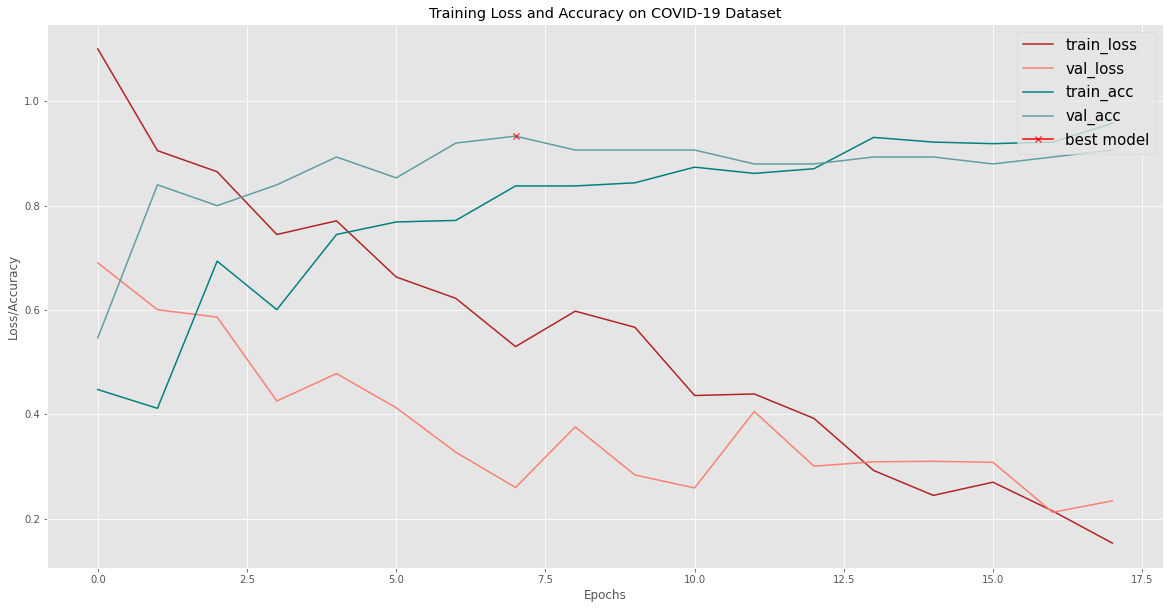

In [27]:
N = len(results.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (20,10))
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss", color = 'firebrick')
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss", color = 'salmon')
plt.plot(np.arange(0, N), results.history["accuracy"], label="train_acc", color = 'teal')
plt.plot(np.arange(0, N), results.history["val_accuracy"], label="val_acc",color = 'cadetblue')
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right", fontsize=15)
plt.savefig('loss_curve.pdf', format='pdf')
plt.show()

compute the confusion matrix and and use it to derive the raw accuracy, sensitivity, and specificity

In [28]:
from matplotlib.font_manager import FontProperties

def plot_cm(labels, predictions):
    '''
    Plot the confusion matrix
    '''

    font = FontProperties()
    font.set_family('serif')
    font.set_name('Times New Roman')
    # font.set_style('italic')

    print(classification_report(labels, predictions, target_names=['Normal', 'Covid-19'], digits=3))

    cm = confusion_matrix(labels, predictions)
    print()

    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 20})
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title('Confusion Matrix',fontsize=30, fontweight='bold')
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label: Normal (0), Covid-19 (1)', fontsize=20)

In [29]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(trueIdxs, predIdxs)

loss :  0.400
accuracy :  0.817

              precision    recall  f1-score   support

      Normal      0.844     0.890     0.867        73
    Covid-19      0.750     0.667     0.706        36

    accuracy                          0.817       109
   macro avg      0.797     0.779     0.786       109
weighted avg      0.813     0.817     0.814       109




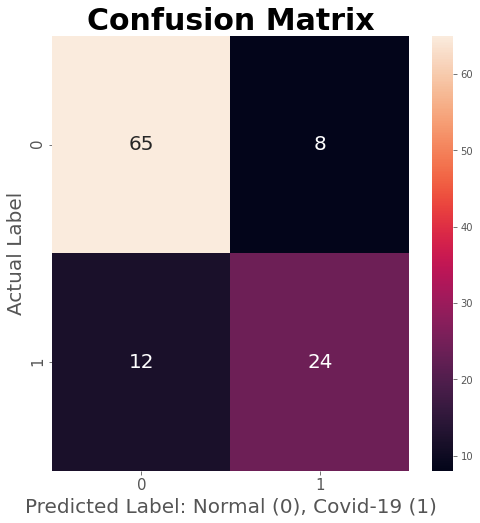

In [30]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='adam', metrics=["accuracy"])
predicted_metrics = model.evaluate(testX, testY,
                                  batch_size=batch_size, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
    print(name, ': ', "%.3f" % value)
print()

plot_cm(trueIdxs, predIdxs)
# plt.savefig('confusion_matrix.pdf', format='pdf')

In [31]:
print("Sensitivity",sensitivity,"Spec",specificity,"Acc",accuracy)

Sensitivity 0.6666666666666666 Spec 0.8904109589041096 Acc 0.8165137614678899
